In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from helpers import *
import random
from tensorly.decomposition import parafac, non_negative_parafac, tucker, Tucker
from scipy.stats import zscore
from scipy.spatial.distance import jensenshannon
import tensorly as tl

In [2]:
def update_interlayer(spikes, size, X = 0.5, omega_global = 1, percentage = 0.01, method = 'local'):
    
    layers ,num_neurons, t = size[0], size[1], size[2] #self.length, self.size, self.windowsize
        
    binned_spikes = bin_time_series(spikes, t, gaussian = False)
    sp = np.nonzero(binned_spikes)
        
    count_spikes = np.zeros((layers, num_neurons))
    interlayer = np.ones((layers-1, num_neurons))
    
    if method == 'local':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        for i in range(layers-1):
            zscores = zscore(np.diff(count_spikes, axis = 0)[i])
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage*omega_global)
                else: layerweights.append(omega_global)
            interlayers.append(layerweights)

    elif method == 'global':
        for i in range(len(sp[0])):
            l, n, t = sp[0][i], sp[1][i], sp[2][i]
            count_spikes[l][n] = count_spikes[l][n] + 1
        interlayers = []
        zscores = zscore(np.mean(np.diff(count_spikes, axis = 0)))###changed np.mean from np.sum
        for i in range(layers-1):
            layerweights = []
            for j in range(num_neurons):
                if zscores[j] <= X: layerweights.append(percentage*omega_global)
                else: layerweights.append(omega_global)
            interlayers.append(layerweights)
    
        #TODO:::  elif method == 'adjacent':
    
    return(interlayers)

def get_normalized_outlinks(thresholded_adjacency, shape, interlayer): 
    #interlayer is the node itselves edge weight that is connected to its future self that is the maximal
    interlayer_indices = {}
    interlayer_weights = {}
    length, size = shape[0], shape[1]
    
    for i in range(length):
        layerweights = []
        
        for j in range(size):
            maximal_neighbors = [[int(interlayer),j]]
            
            for nonzero in np.nonzero(thresholded_adjacency[j,:,i])[0]:
                maximal_neighbors.append([thresholded_adjacency[j,nonzero,i], nonzero])
                
            weights = np.array(sorted(maximal_neighbors, reverse = True))[:,0]
            indices = np.array(sorted(maximal_neighbors, reverse = True))[:,1]
            
            norm_weights = weights/np.sum(weights)
            indices, norm_weights
            
            interlayer_indices['%d,%d'%(i,j)] = indices
            interlayer_weights['%d,%d'%(i,j)] = norm_weights
            
    return(interlayer_indices, interlayer_weights)
    
def neighborhood_flow(layer, node, interlayer_indices, interlayer_weights, thresh):
    
    
    length = int(min(len(interlayer_weights['%d,%d'%(layer,node)]), 
                     len(interlayer_weights['%d,%d'%(layer+1,node)]))*thresh)
    
    w = 1-jensenshannon(interlayer_weights['%d,%d'%(layer,node)][:length], 
                        interlayer_weights['%d,%d'%(layer+1,node)][:length])**2
    
    nbr = interlayer_indices['%d,%d'%(layer,node)][:length]
    
    return(w,nbr)

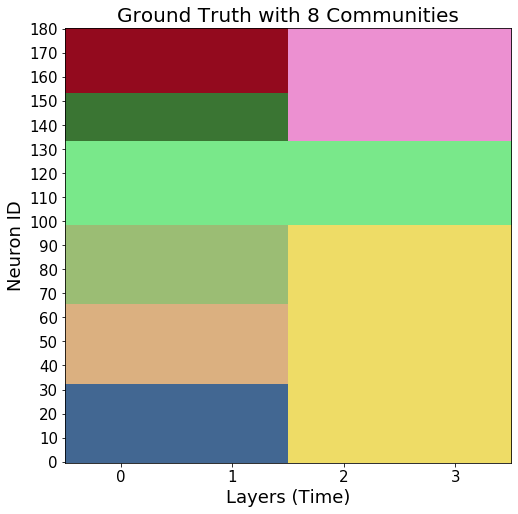

In [8]:
comms1 = 6
comms2 = 3

layers = 2

fixed_size = [int(abs(np.random.normal(30,10))) for i in range(comms1)]

fixed_rate1 = int(abs(np.random.normal(20,8)))
fixed_rate2 = int(abs(np.random.normal(20,8)))# spike rate per commiunity


comm_sizes = [int(np.random.power(3/2)*30) for i in range(layers)]
spike_rates = [int(abs(np.random.normal(20,8))) for i in range(layers)]

comm_sizes = [fixed_size, #layer1 community sizes
              [fixed_size[0]+fixed_size[1]+fixed_size[2],fixed_size[3],fixed_size[4]+fixed_size[5]]] #layer2 community sizes
spike_rates = [[fixed_rate1 for i in range(comms1)],
              [fixed_rate2 for i in range(comms2)]]

window_size = 1000 # size, in frames, each adjacency matrix correspond to. better to be equal to bin_size 
standard_dev = 1.2 # for gaussian kernel
k = 5 #for jittering the spikes
pad = True
num_neurons = sum(comm_sizes[0])

display_truth(comm_sizes, community_operation = 'merge')

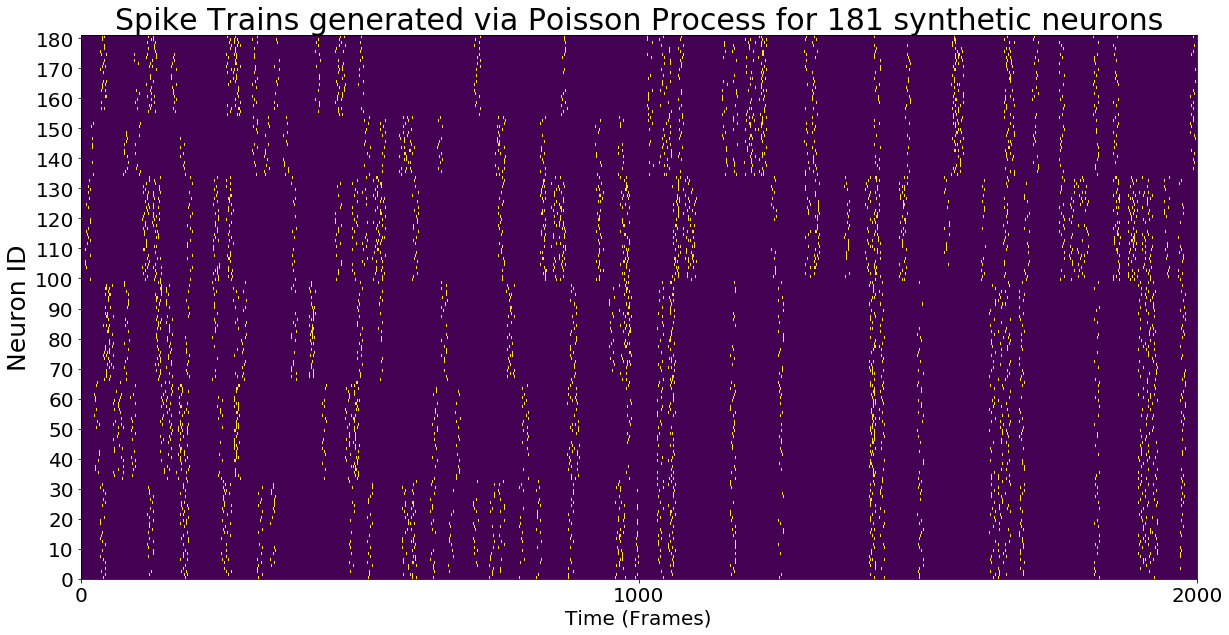

In [9]:
spikes = create_time_series('merge', comm_sizes, spike_rates, windowsize = window_size, k = k)

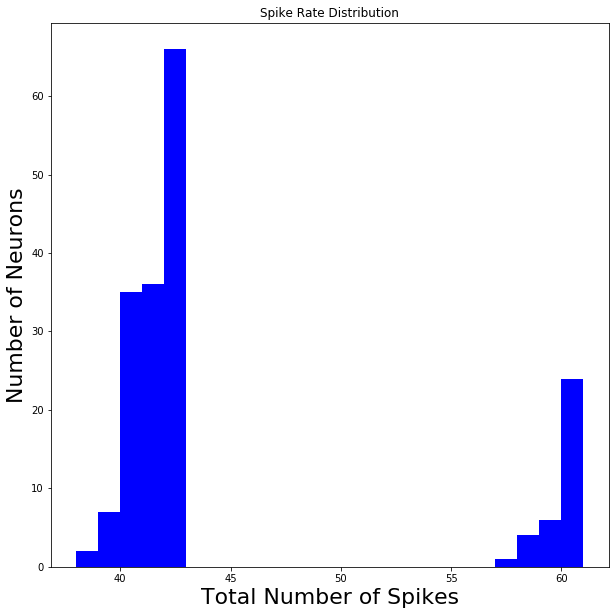

In [10]:
fig,ax = plt.subplots(1, 1, figsize = (10,10))
n, bins = spike_count(spikes, ax)

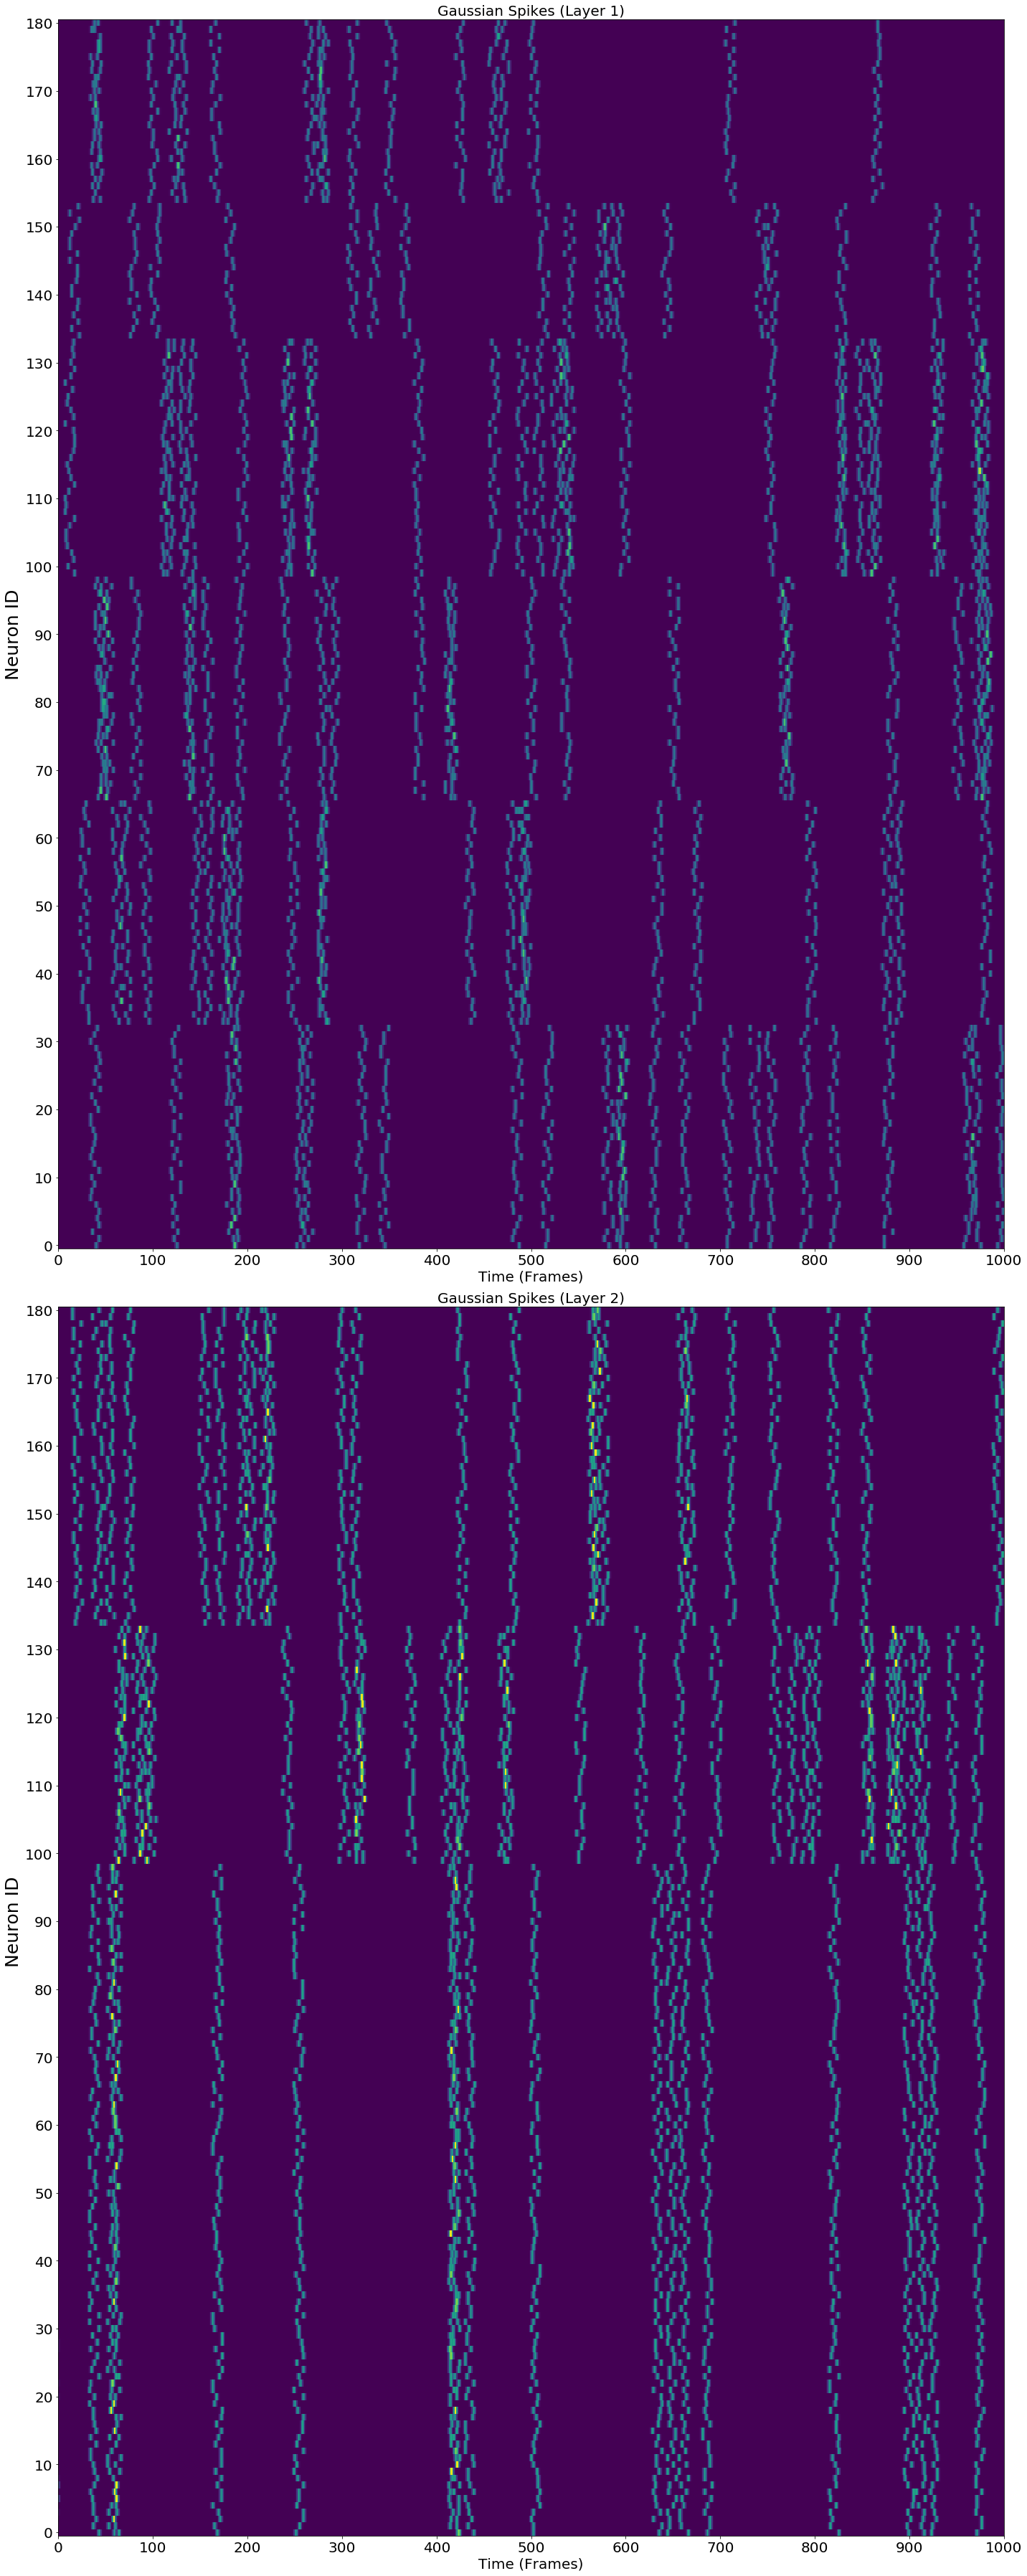

In [11]:
binned_spikes = bin_time_series(spikes, window_size, gaussian = True, sigma = standard_dev)
fig,ax = plt.subplots(layers, 1, figsize=(20,50))
for i in range(layers):
    ax[i].imshow(binned_spikes[i], origin = 'lower', interpolation='nearest', aspect='auto')
    ax[i].set_title('Gaussian Spikes (Layer %d)'%(i+1), fontsize = 20)
    ax[i].set_xlabel('TIME (in Miliseconds)', fontsize = 20)
    ax[i].set_xticks([j*100 for j in range(11)])
    ax[i].set_yticks([j*10 for j in range(int(num_neurons/10)+1)])
    ax[i].set_ylabel('Neuron ID', fontsize = 25)
    ax[i].set_xlabel('Time (Frames)', fontsize = 20)
    ax[i].tick_params(axis = 'both', labelsize = 20)
plt.tight_layout()

In [12]:
##create cross-correlation matrices that are the adjacency matrices of the network at each layer
adjacency_matrices = []
for i in range(layers):
    adjacency_matrices.append(cross_correlation_matrix(binned_spikes[i])[0])
    
if pad:
    padded_adjacencies = [adjacency_matrices[0]]  + adjacency_matrices + [adjacency_matrices[-1]]
    layers = layers + 2

/Users/bengieru/MLN/Experiments/helpers.py:29: RuntimeWarning: invalid value encountered in sqrt
  x_cov_std = np.nanmax(np.sqrt(np.correlate(x - x_mean, x - x_mean, 'full')))
/Users/bengieru/MLN/Experiments/helpers.py:30: RuntimeWarning: invalid value encountered in sqrt
  y_cov_std = np.nanmax(np.sqrt(np.correlate(y - y_mean, y - y_mean, 'full')))


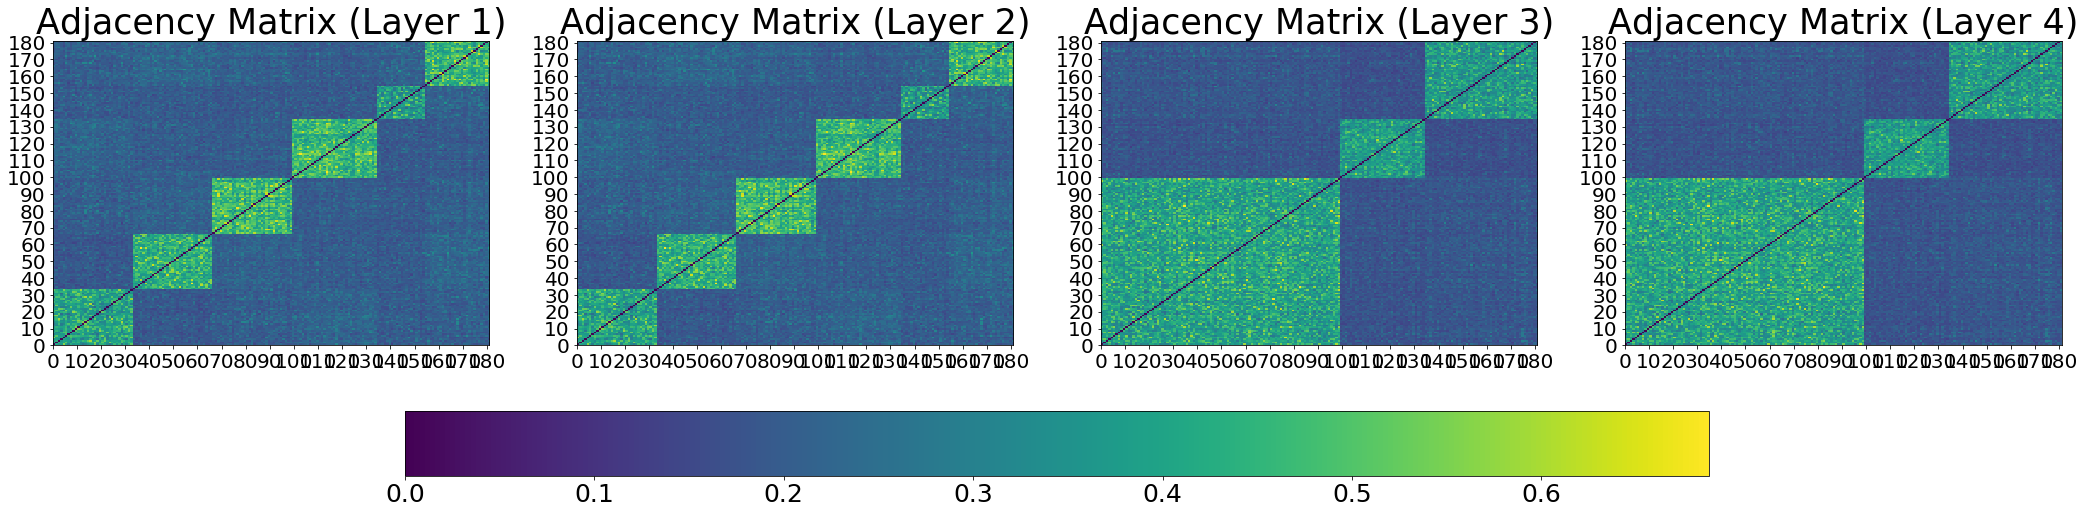

In [15]:
fig,ax = plt.subplots(1, 4, figsize = (36,8))
for i in range(4):
        k = ax[i].imshow(padded_adjacencies[i], 
                            origin = 'lower', 
                            interpolation='nearest', 
                            aspect='auto',  
                            extent = [0,num_neurons,0,num_neurons])
        ax[i].set_title('Adjacency Matrix (Layer %d)'%(i +1), fontsize = 35)
        ax[i].set_xticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i].set_yticks([k*10 for k in range(int(num_neurons/10)+1)])
        ax[i].tick_params(axis = 'both', labelsize = 20)
#fig.suptitle('Community expansion with sizes %d,%d,%d,%d and spike rates %d,%d,%d,%d'%(comm_sizes[0],comm_sizes[1],comm_sizes[2],comm_sizes[3],spike_rates[0],spike_rates[1],spike_rates[2],spike_rates[3]), fontsize = 20)
cbar = fig.colorbar(k, ax = ax.flat, orientation = 'horizontal')
cbar.ax.tick_params(labelsize = 25) 
#plt.savefig(path + 'adjacency.pdf')

In [16]:
tensor_default = np.zeros((num_neurons,num_neurons,layers))
tensor_local = np.zeros((num_neurons,num_neurons,int((2*layers)-1)))
tensor_nbr = np.zeros((num_neurons,num_neurons,int((2*layers)-1)))

thresh = 0.2
for i in range(layers):
    tensor_default[:,:,i] = binarize(padded_adjacencies[i], thresh)
X_0 = tl.tensor(tensor_default)

inters = update_interlayer(spikes, [layers, num_neurons, window_size])
for i in range(int((2*layers)-1)):
    if i%2 == 0:
        tensor_local[:,:,i] = binarize(padded_adjacencies[int(i/2)], thresh)
    else:
        tensor_local[:,:,i] = np.diag(inters[int((i-1)/2)])
X_1 = tl.tensor(tensor_local)

updated_interlayer_indices, updated_interlayer_weights = get_normalized_outlinks(tensor_default, [layers, num_neurons], 1)
for i in range(int((2*layers)-1)):
    if i%2 == 0:
        tensor_nbr[:,:,i] = binarize(padded_adjacencies[int(i/2)], thresh)
    else:
        inter_layer = np.zeros((num_neurons,num_neurons))
        for k in range(num_neurons):
            w, nbr = neighborhood_flow(int(i/2), k, updated_interlayer_indices, updated_interlayer_weights, thresh)
            if np.isnan(w):
                w = 1.0
            for n in nbr:
                inter_layer[k,int(n)] = w
                
        tensor_nbr[:,:,i] = inter_layer
X_2 = tl.tensor(tensor_nbr)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/opt/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1296: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [17]:
ranks = [i for i in range(2,20)]
weights_0 = []
factors_0 = []

weights_1 = []
factors_1 = []

weights_2 = []
factors_2 = []

for r in ranks:
    weights_parafac_0, factors_parafac_0 = non_negative_parafac(X_0, rank = r, n_iter_max = 500, init = 'random')
    weights_0.append(weights_parafac_0)
    factors_0.append(factors_parafac_0)
    
    weights_parafac_1, factors_parafac_1 = non_negative_parafac(X_1, rank = r, n_iter_max = 500, init = 'random')
    weights_1.append(weights_parafac_1)
    factors_1.append(factors_parafac_1)
    
    weights_parafac_2, factors_parafac_2 = non_negative_parafac(X_2, rank = r, n_iter_max = 500, init = 'random')
    weights_2.append(weights_parafac_2)
    factors_2.append(factors_parafac_2)

In [18]:
comm_matrices_0 = {}
for r,e in enumerate(ranks):
    comms_0 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_0[i][j] = np.argmax(((factors_0[r][0][i]+factors_0[r][1][i])/2)*factors_0[r][2][j])
    comm_matrices_0['%d'%r] = comms_0
    
comm_matrices_1 = {}
for r,e in enumerate(ranks):
    comms_1 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_1[i][j] = np.argmax(((factors_1[r][0][i]+factors_1[r][1][i])/2*factors_1[r][2][int(j*2)]))
    comm_matrices_1['%d'%r] = comms_1

comm_matrices_2 = {}
for r,e in enumerate(ranks):
    comms_2 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_2[i][j] = np.argmax(((factors_2[r][0][i]+factors_2[r][1][i])/2*factors_2[r][2][int(j*2)]))
    comm_matrices_2['%d'%r] = comms_2

In [19]:
activity = {}
for r,e in enumerate(ranks):
    C = np.zeros((e,layers))
    for i in range(layers):
        C[:,i] = np.sum(factors_0[r][0], axis = 0)*factors_0[r][2][i]
    activity['%d'%e] = C        

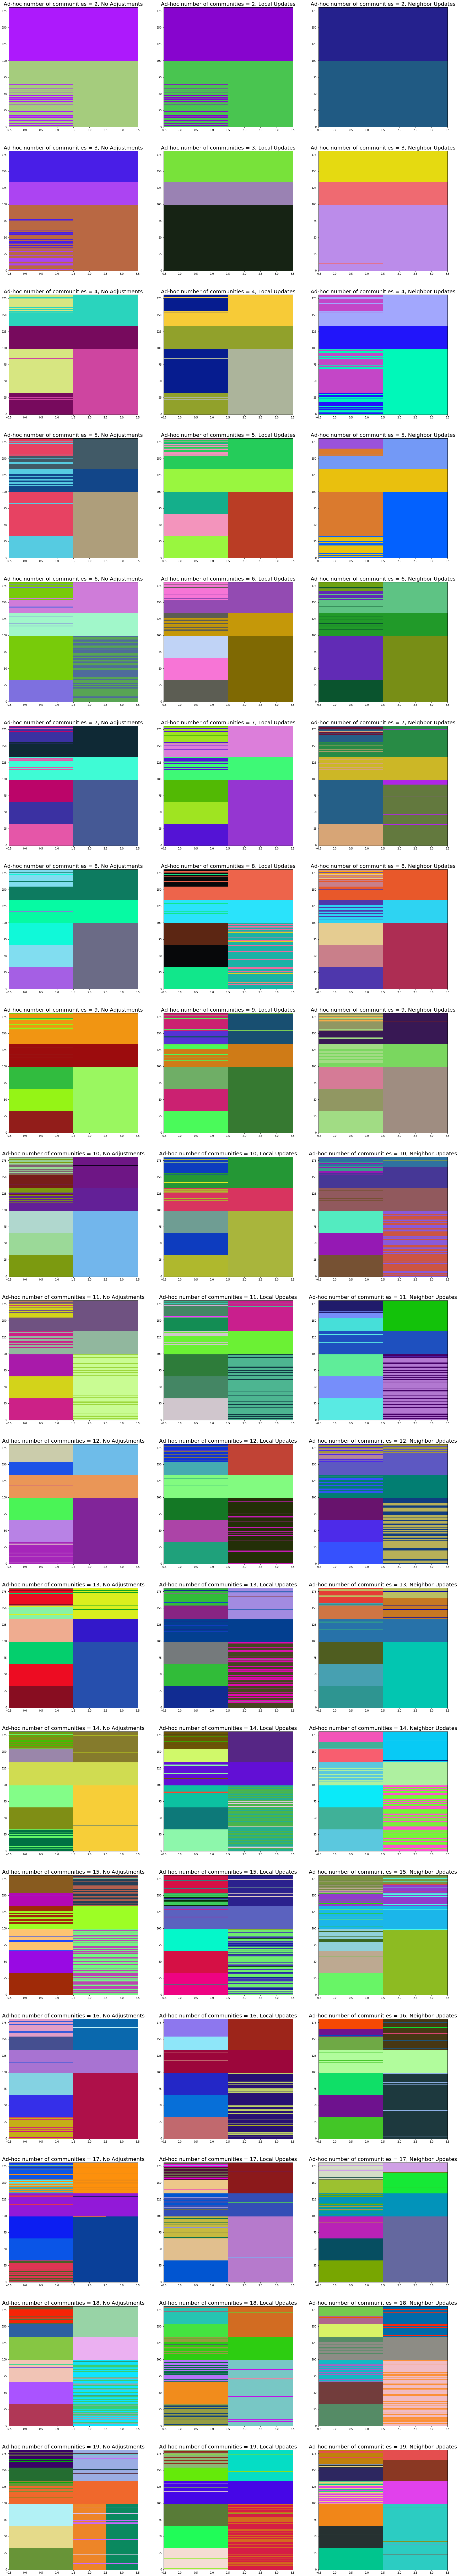

In [20]:
fig,ax = plt.subplots(len(ranks),3,figsize = (30,10*len(ranks)))

for r,e in enumerate(ranks):
    membership_0 = [[] for i in range(e)]
    membership_1 = [[] for i in range(e)]
    membership_2 = [[] for i in range(e)]
    for j in range(num_neurons):
        for k in range(layers):
            node_id_0 = int(comm_matrices_0['%d'%r][j][k])
            membership_0[node_id_0].append((j,k))
            
            node_id_1 = int(comm_matrices_1['%d'%r][j][k])
            membership_1[node_id_1].append((j,k))
            
            node_id_2 = int(comm_matrices_2['%d'%r][j][k])
            membership_2[node_id_2].append((j,k))
            
    number_of_colors_0 = len(membership_0)
    number_of_colors_1 = len(membership_1)
    number_of_colors_2 = len(membership_2)

    comms_0 = np.zeros((num_neurons,layers))
    comms_1 = np.zeros((num_neurons,layers))
    comms_2 = np.zeros((num_neurons,layers))

    color_0 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_0)]
    color_1 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_1)]
    color_2 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_2)]


    for i, l in enumerate(membership_0):
        for j,k in enumerate(l):
            comms_0[k[0]][k[1]] = i
    for i, l in enumerate(membership_1):
        for j,k in enumerate(l):
            comms_1[k[0]][k[1]] = i
    for i, l in enumerate(membership_2):
        for j,k in enumerate(l):
            comms_2[k[0]][k[1]] = i

    cmap_0 = mpl.colors.ListedColormap(color_0)
    cmap_1 = mpl.colors.ListedColormap(color_1)
    cmap_2 = mpl.colors.ListedColormap(color_2)

    ax[r][0].imshow(comms_0, interpolation = 'none', cmap = cmap_0, aspect = 'auto', origin = 'lower')
    ax[r][0].set_title('Ad-hoc number of communities = %d, No Adjustments'%e, fontsize = 20)
    
    ax[r][1].imshow(comms_1, interpolation = 'none', cmap = cmap_1, aspect = 'auto', origin = 'lower')
    ax[r][1].set_title('Ad-hoc number of communities = %d, Local Updates'%e, fontsize = 20)
    
    ax[r][2].imshow(comms_2, interpolation = 'none', cmap = cmap_2, aspect = 'auto', origin = 'lower')
    ax[r][2].set_title('Ad-hoc number of communities = %d, Neighbor Updates'%e, fontsize = 20)

In [21]:
comm_matrices_0_A = {}
for r,e in enumerate(ranks):
    comms_0 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_0[i][j] = np.argmax(((factors_0[r][0][i])*factors_0[r][2][j]))
    comm_matrices_0_A['%d'%r] = comms_0
    
comm_matrices_1_A = {}
for r,e in enumerate(ranks):
    comms_1 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_1[i][j] = np.argmax(((factors_1[r][0][i])*factors_1[r][2][int(j*2)]))
    comm_matrices_1_A['%d'%r] = comms_1

comm_matrices_2_A = {}
for r,e in enumerate(ranks):
    comms_2 = np.zeros((num_neurons,layers))
    for i in range(num_neurons):
        for j in range(layers):
            comms_2[i][j] = np.argmax(((factors_2[r][0][i])*factors_2[r][2][int(j*2)]))
    comm_matrices_2_A['%d'%r] = comms_2

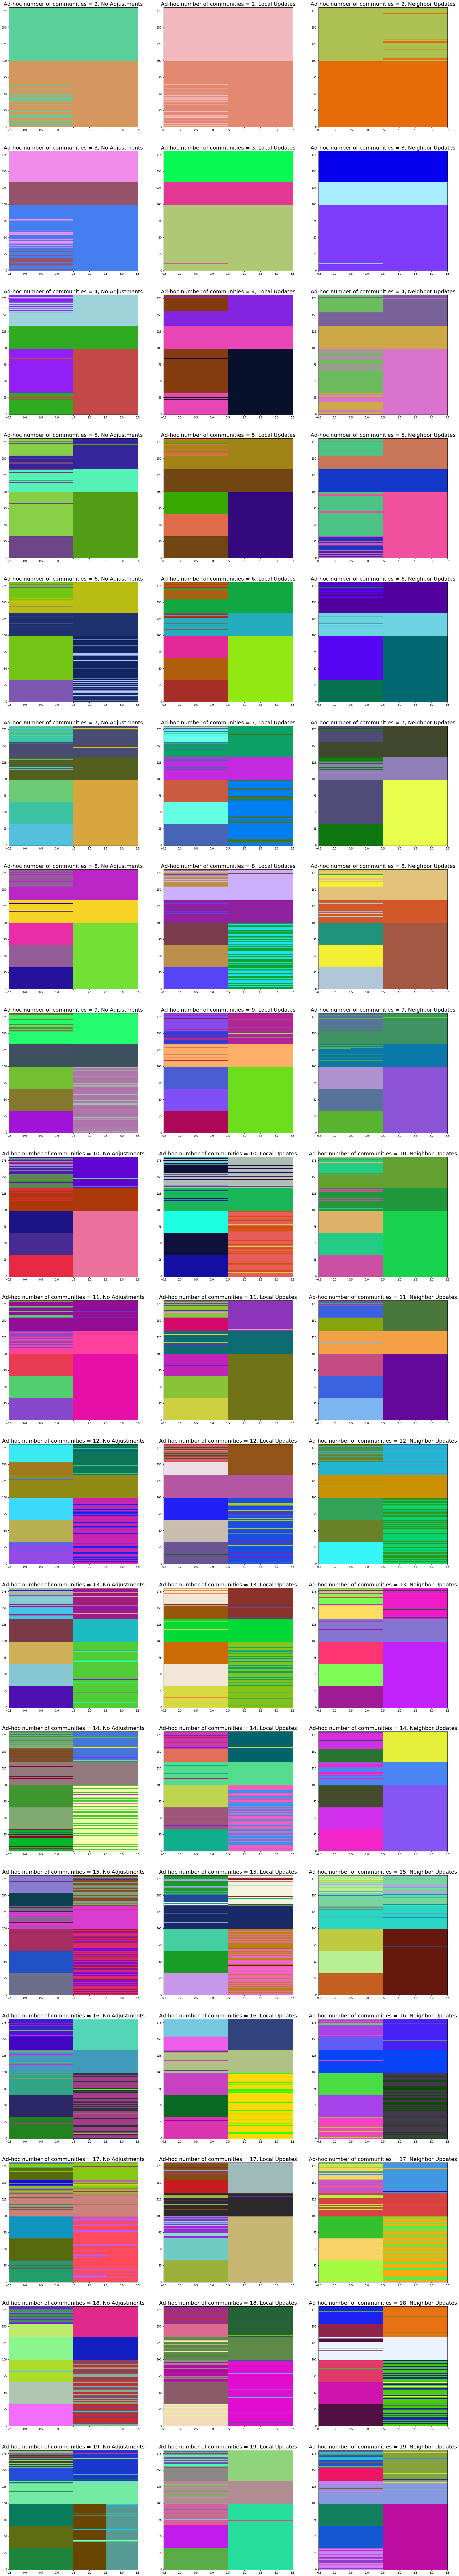

In [22]:
fig,ax = plt.subplots(len(ranks),3,figsize = (30,10*len(ranks)))

for r,e in enumerate(ranks):
    membership_0 = [[] for i in range(e)]
    membership_1 = [[] for i in range(e)]
    membership_2 = [[] for i in range(e)]
    for j in range(num_neurons):
        for k in range(layers):
            node_id_0 = int(comm_matrices_0_A['%d'%r][j][k])
            membership_0[node_id_0].append((j,k))
            
            node_id_1 = int(comm_matrices_1_A['%d'%r][j][k])
            membership_1[node_id_1].append((j,k))
            
            node_id_2 = int(comm_matrices_2_A['%d'%r][j][k])
            membership_2[node_id_2].append((j,k))
            
    number_of_colors_0 = len(membership_0)
    number_of_colors_1 = len(membership_1)
    number_of_colors_2 = len(membership_2)

    comms_0 = np.zeros((num_neurons,layers))
    comms_1 = np.zeros((num_neurons,layers))
    comms_2 = np.zeros((num_neurons,layers))

    color_0 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_0)]
    color_1 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_1)]
    color_2 = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors_2)]


    for i, l in enumerate(membership_0):
        for j,k in enumerate(l):
            comms_0[k[0]][k[1]] = i
    for i, l in enumerate(membership_1):
        for j,k in enumerate(l):
            comms_1[k[0]][k[1]] = i
    for i, l in enumerate(membership_2):
        for j,k in enumerate(l):
            comms_2[k[0]][k[1]] = i

    cmap_0 = mpl.colors.ListedColormap(color_0)
    cmap_1 = mpl.colors.ListedColormap(color_1)
    cmap_2 = mpl.colors.ListedColormap(color_2)

    ax[r][0].imshow(comms_0, interpolation = 'none', cmap = cmap_0, aspect = 'auto', origin = 'lower')
    ax[r][0].set_title('Ad-hoc number of communities = %d, No Adjustments'%e, fontsize = 20)
    
    ax[r][1].imshow(comms_1, interpolation = 'none', cmap = cmap_1, aspect = 'auto', origin = 'lower')
    ax[r][1].set_title('Ad-hoc number of communities = %d, Local Updates'%e, fontsize = 20)
    
    ax[r][2].imshow(comms_2, interpolation = 'none', cmap = cmap_2, aspect = 'auto', origin = 'lower')
    ax[r][2].set_title('Ad-hoc number of communities = %d, Neighbor Updates'%e, fontsize = 20)